In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dynamics import Motor, TimeStepInvariantMotor

import os

%matplotlib widget
plt.ion()

In [2]:
# Instantiate motor
# motor = Motor()
motor = TimeStepInvariantMotor()

# Simulate function

In [3]:
def simulate_motor(motor, controller, duration = 30):
	# Simulate the given motor with PWM output from the given controller for the given duration
	# Save the time, throttle, current, torque, drag, rpm and thrust data to a dataframe

	# Initialize dataframe
	df = pd.DataFrame(columns = ['time', 'throttle', 'current', 'torque', 'drag', 'rpm', 'thrust'])

	# Simulate
	while controller.get_current_time() < duration:
		# Save data
		data = {}
		data['time'] = controller.get_current_time()
		motor.step(controller.get_pwm(motor), controller.dt)

		data['throttle'] = motor.throttle
		data['current'] = motor.current
		data['torque'] = motor.torque
		data['drag'] = motor.drag_torque
		data['rpm'] = motor.rpm
		data['thrust'] = motor.thrust
		df_row = pd.DataFrame(data, index = [df.shape[0]])
		df = pd.concat([df, df_row], axis = 0)
	return df

# Controllers

In [4]:

class StepController:
	def __init__(self, dt = 0.02, step_value = 1500, step_time = 0.1):
		self.dt = dt
		self.step_value = step_value
		self.step_time = step_time
		self.step_counter = 0
  
	def get_pwm(self, motor):
		# Get throttle based on step size, step time, and step counter
		throttle = self.step_value
		if self.step_counter * self.dt < self.step_time:
			throttle = 1000
		self.step_counter += 1
		return throttle

	def get_current_time(self):
		return self.step_counter * self.dt

class RampController:
	def __init__(self, dt = 0.02, final_value = 1500, ramp_time = 0.1, ramp_start = 0.1):
		self.dt = dt
		self.final_value = final_value
		self.ramp_time = ramp_time
		self.ramp_start = ramp_start
		self.step_counter = 0
  
	def get_pwm(self, motor):
		# Get throttle based on step size, step time, and step counter
		throttle = self.final_value
		if self.step_counter * self.dt < self.ramp_start:
			throttle = 1000
		elif self.step_counter * self.dt < self.ramp_time + self.ramp_start:
			throttle = 1000 + (self.final_value - 1000) * (self.step_counter * self.dt - self.ramp_start) / self.ramp_time
		self.step_counter += 1
		return throttle

	def get_current_time(self):
		return self.step_counter * self.dt

class PulseController:
	def __init__(self, dt = 0.02, pulse_value = 1500, pulse_time = 0.1, pulse_period = 0.1):
		self.dt = dt
		self.pulse_value = pulse_value
		self.pulse_time = pulse_time
		self.pulse_period = pulse_period
		self.step_counter = 0

	def get_pwm(self, motor):
		# Get throttle based on step size, step time, and step counter
		throttle = self.pulse_value
		if self.step_counter * self.dt < self.pulse_time or self.step_counter * self.dt > self.pulse_time + self.pulse_period:
			throttle = 1000
		self.step_counter += 1
		return throttle

	def get_current_time(self):
		return self.step_counter * self.dt

# Save DF

In [5]:
# Save df to csv under "results" folder
def save_df(df):
	if not os.path.exists('results'):
		os.makedirs('results')
	
	if not os.path.isfile('results/last.csv'):
		with open('results/last.csv', 'w') as f:
			f.write('0')
	
	save_num = 1
	with open('results/last.csv', 'r') as f:
		save_num = int(f.read()) + 1
	
	df.to_csv('results/' + str(save_num) + '.csv', index=False)
	with open('results/last.csv', 'w') as f:
		f.write(str(save_num))

# Plot Results

In [6]:
def plot_results(df, title = ''):
    # Plot throttle, torque, drag and rpm vs time with separate y-axes
    fig, ax1 = plt.subplots()
    ax1.plot(df['time'].values, df['rpm'].values, 'b-')
    ax1.set_xlabel('Time / s')
    ax1.set_ylabel('RPM', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(df['time'].values, df['torque'].values, 'r-')
    ax2.set_ylabel('Torque', color='r')
    ax2.tick_params('y', colors='r')

    ax3 = ax1.twinx()
    ax3.plot(df['time'].values, df['drag'].values, 'g-')
    ax3.set_ylabel('Prop Drag', color='g')
    ax3.tick_params('y', colors='g')

    ax4 = ax1.twinx()
    ax4.plot(df['time'].values, df['throttle'].values, 'm-')
    ax4.set_ylabel('Throttle', color='m')
    ax4.tick_params('y', colors='m')

    # Add purple dots at y = -0.05 wherever rpm == 0
    ax2.plot(df['time'].values[df['rpm'].values == 0], np.full(len(df['time'].values[df['rpm'].values == 0]), -0.05), 'm.')

    # Space out the y-axes
    ax2.spines['right'].set_position(('axes', 1))
    ax3.spines['right'].set_position(('axes', 1.15))
    ax4.spines['right'].set_position(('axes', 1.3))

    # Scale both y-axes to the same min and max value
    ax2.set_ylim([min(df['torque'].values.min(), df['drag'].values.min()) - 0.1, max(df['torque'].values.max(), df['drag'].values.max()) + 0.5])
    ax3.set_ylim([min(df['torque'].values.min(), df['drag'].values.min()) - 0.1, max(df['torque'].values.max(), df['drag'].values.max()) + 0.5])

    def align_yaxis(ax_mod, ax_ref, mod_ymin, mod_ymax):
        # Scale ax_mod to show the full range of data and set the 0 on y axis to match the 0 on ax_ref
        y_mod = ax_mod.get_ylim()
        y_ref = ax_ref.get_ylim()
        
        # Match the 0 of ax_mod to the 0 of ax_ref
        ref_y_range = y_ref[1] - y_ref[0]
        ref_0_pos = -y_ref[0] / ref_y_range
        mod_y_range = y_mod[1] - y_mod[0]
        mod_0_pos = -y_mod[0] / mod_y_range
        new_y_mod = [y_mod[0] + (mod_0_pos - ref_0_pos) * mod_y_range, y_mod[1] + (mod_0_pos - ref_0_pos) * mod_y_range]
        
        new_0_pos = -new_y_mod[0] / (new_y_mod[1] - new_y_mod[0])
        
        # Scale ax_mod to show the full range of data while keeping the 0 at the same position
        low_diff = new_y_mod[0] - mod_ymin
        high_diff = new_y_mod[1] - mod_ymax
        
        if low_diff > 0:
            new_y_mod[0] -= low_diff
            new_y_mod[1] += low_diff * (1 - new_0_pos) / new_0_pos
        if high_diff < 0:
            new_y_mod[0] += high_diff * new_0_pos / (1 - new_0_pos)
            new_y_mod[1] -= high_diff
            
        if new_y_mod[0] >= mod_ymin:
            factor = 0.05 * (new_y_mod[1] - new_y_mod[0])
            new_y_mod[0] -= factor
            new_y_mod[1] += factor * (1 - new_0_pos) / new_0_pos
        if new_y_mod[1] <= mod_ymax:
            factor = 0.05 * (new_y_mod[1] - new_y_mod[0])
            new_y_mod[0] -= factor * new_0_pos / (1 - new_0_pos)
            new_y_mod[1] += factor
            
        ax_mod.set_ylim(new_y_mod)
        
    align_yaxis(ax1, ax2, df['rpm'].values.min(), df['rpm'].values.max())
    align_yaxis(ax4, ax2, df['throttle'].values.min(), df['throttle'].values.max())
    
    # Add title
    plt.suptitle(title)

    fig.tight_layout()
    plt.show()

# Analysis
## Step controller
### dt = 0.02

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


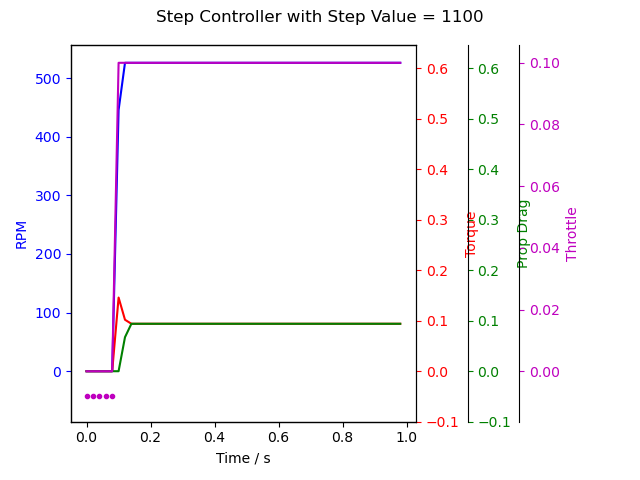

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


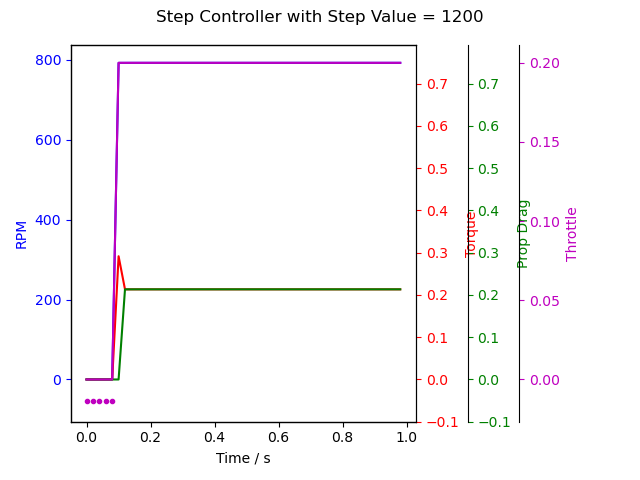

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


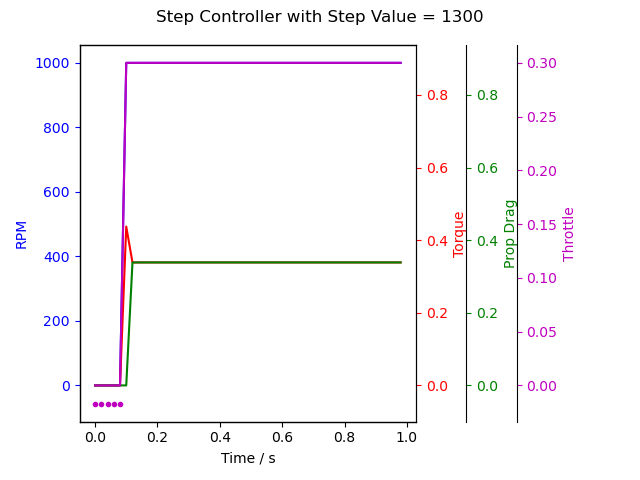

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


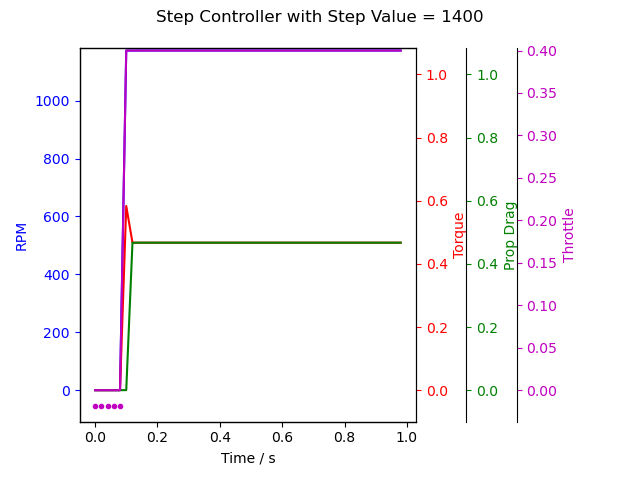

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


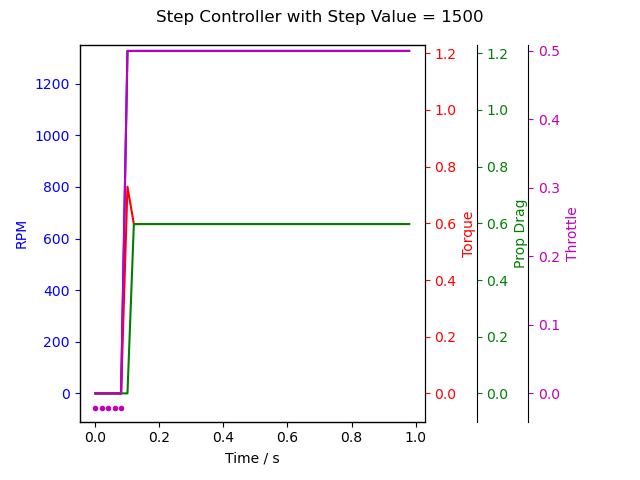

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


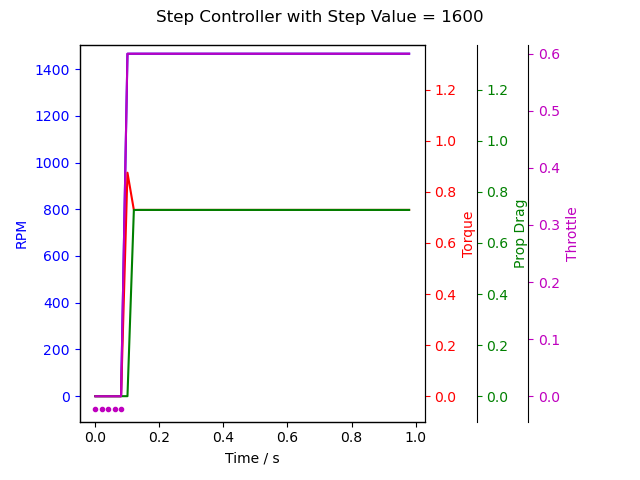

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


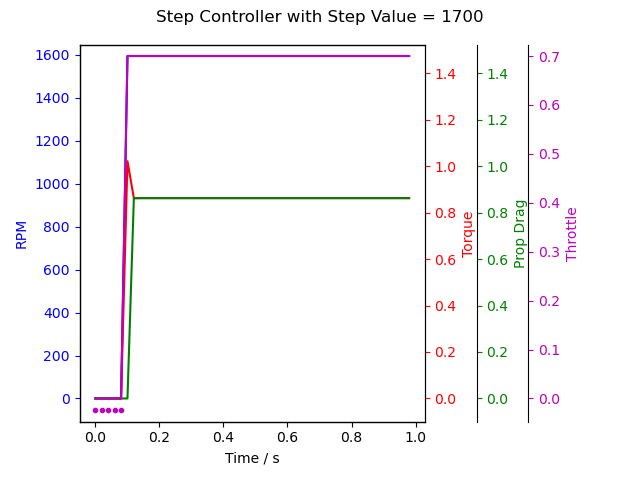

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


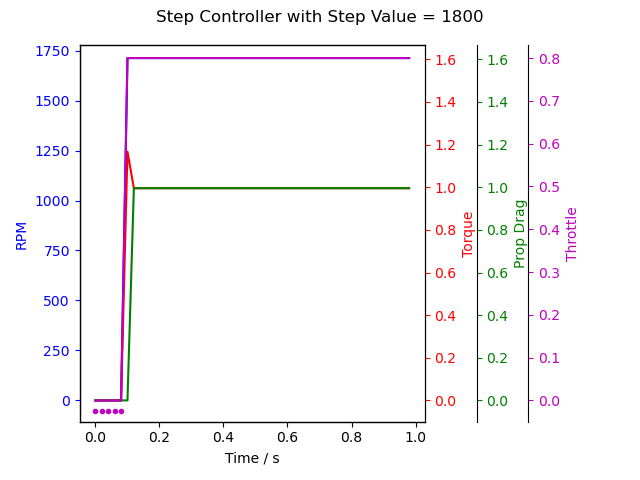

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


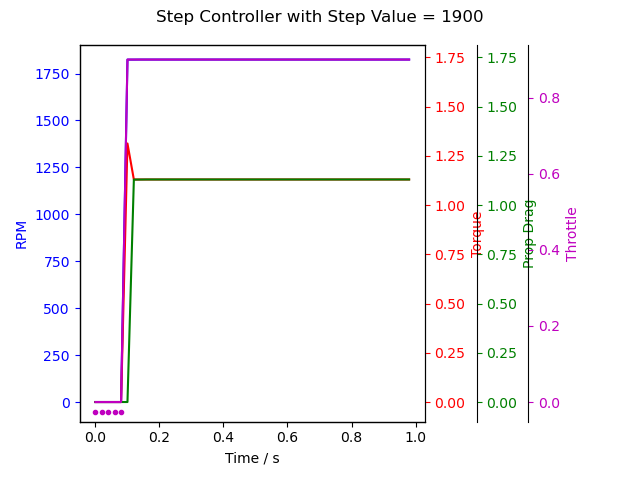

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


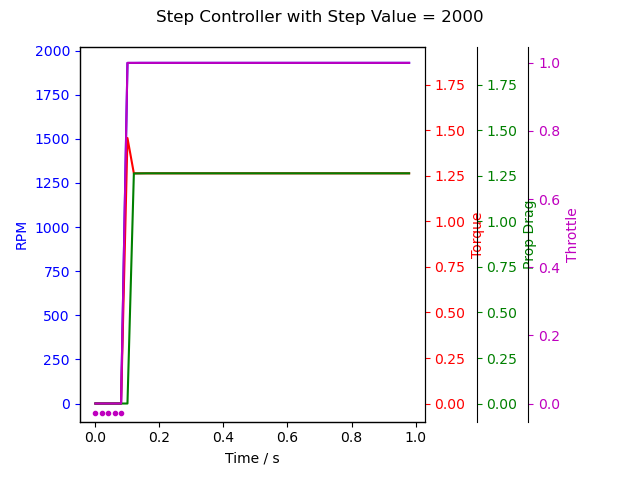

In [7]:
# Perform analysis of the motor for step controllers with varying step values
# Plot the results
step_values = list(range(1100, 2001, 100))
for step_value in step_values:
	motor.reset()
	controller = StepController(step_value = step_value, dt = 0.02)
	df = simulate_motor(motor, controller, duration=1)
	plot_results(df, 'Step Controller with Step Value = ' + str(step_value))

### dt = 0.005

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


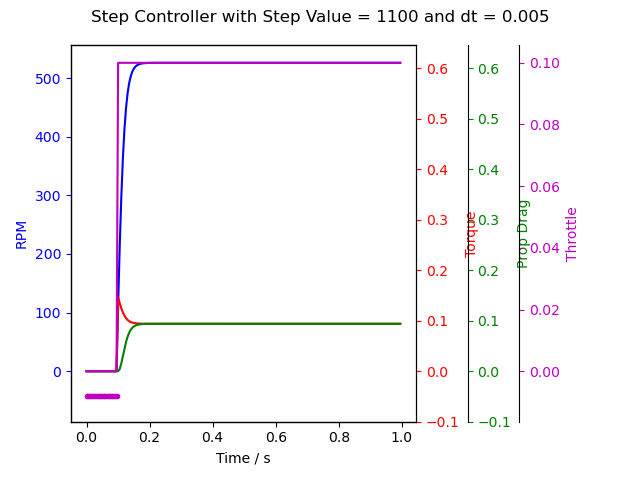

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


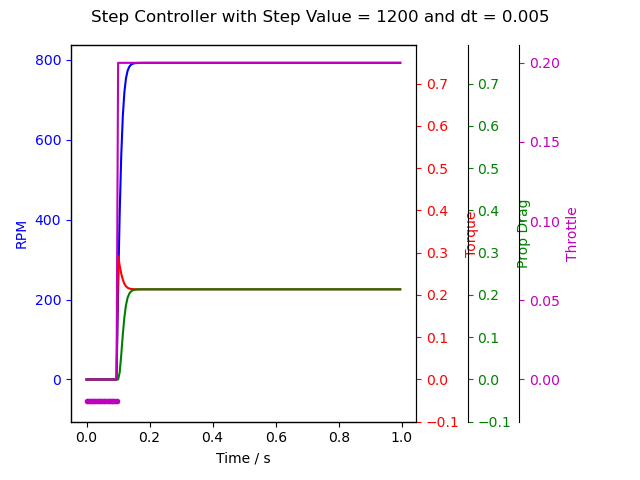

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


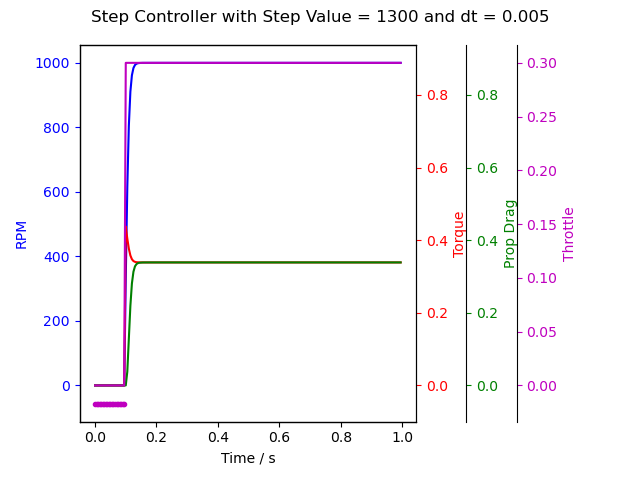

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


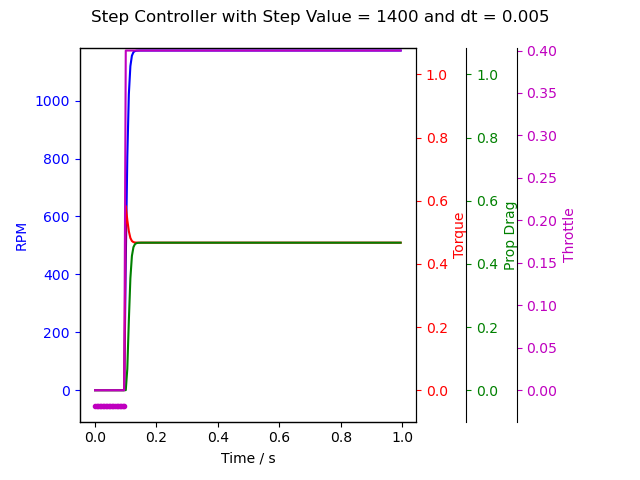

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


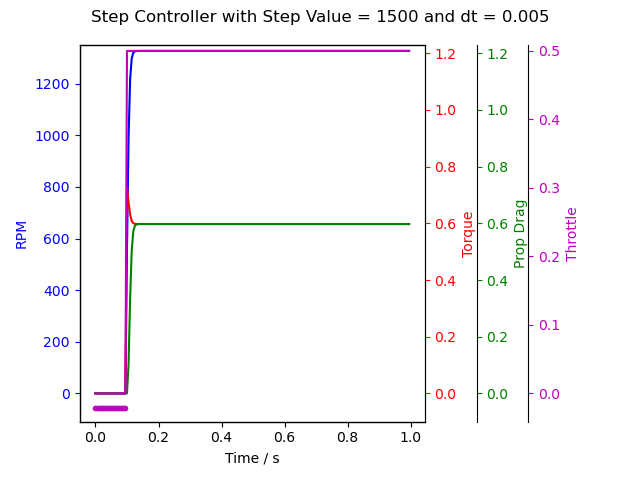

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


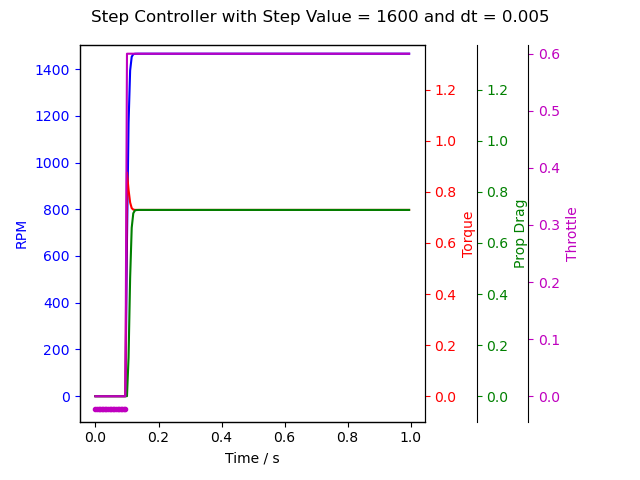

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


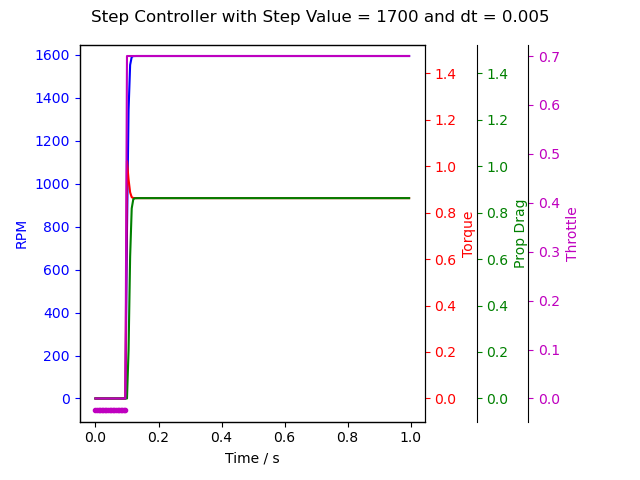

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


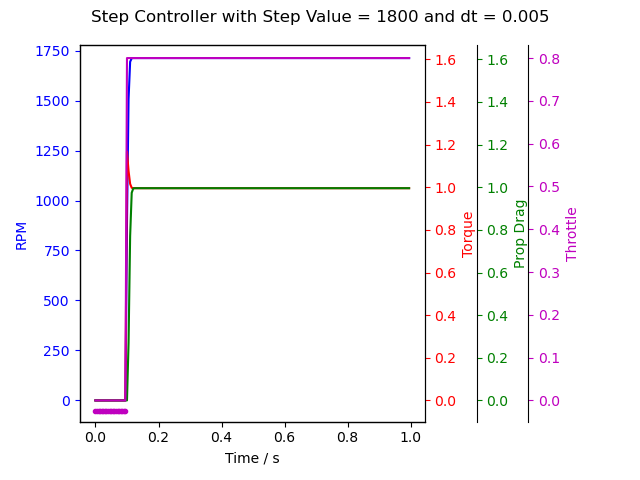

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


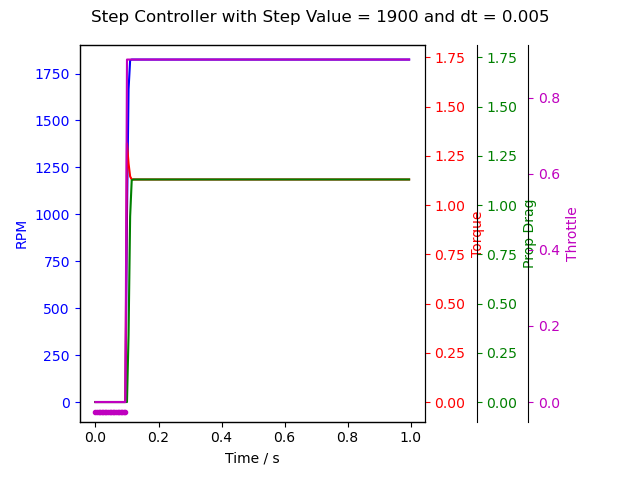

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


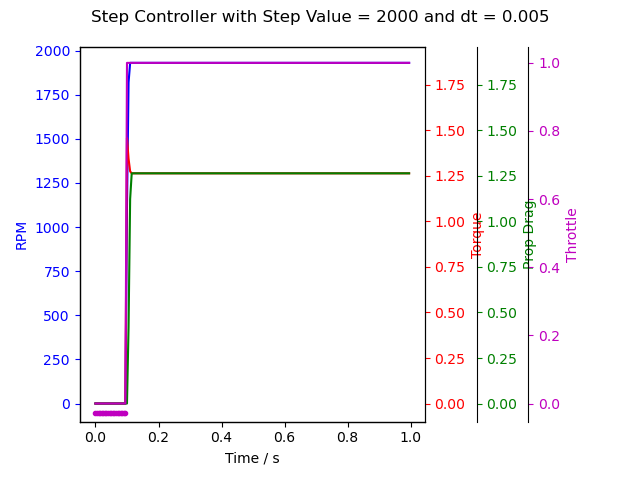

In [8]:
# Perform the same with dt = 0.005
for step_value in step_values:
	motor.reset()
	controller = StepController(step_value = step_value, dt = 0.005)
	df = simulate_motor(motor, controller, duration=1)
	plot_results(df, 'Step Controller with Step Value = ' + str(step_value) + ' and dt = 0.005')

## Ramp controller
### dt = 0.02

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)
/tmp/ipykernel_15763/1816123181.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


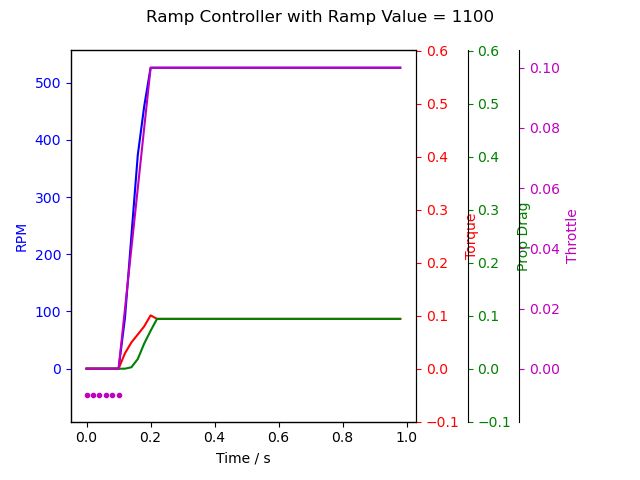

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


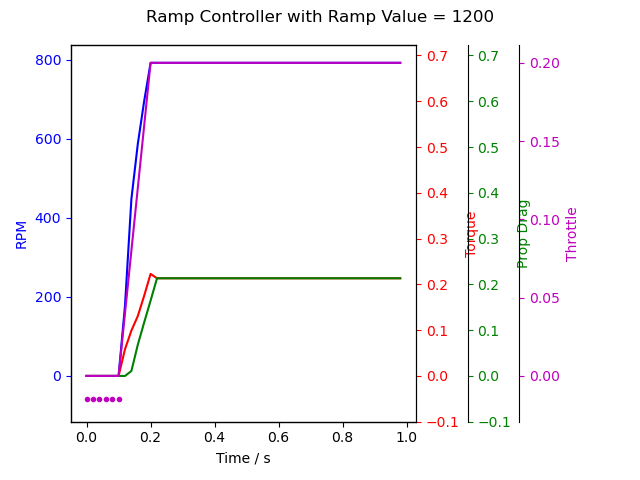

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


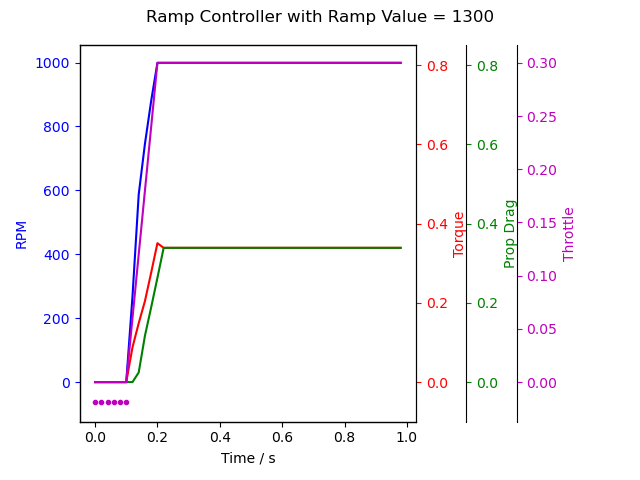

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


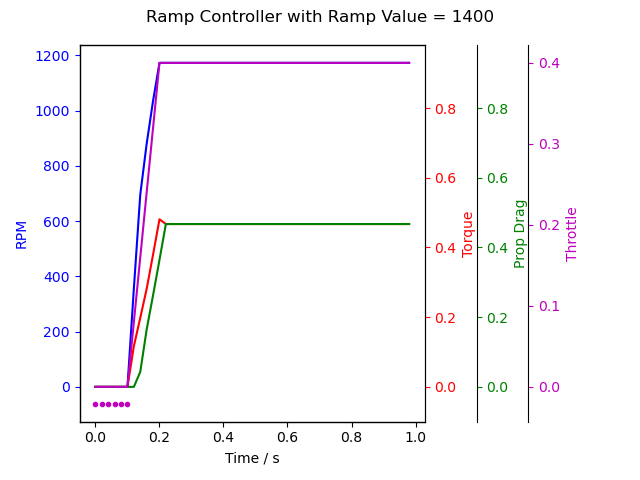

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


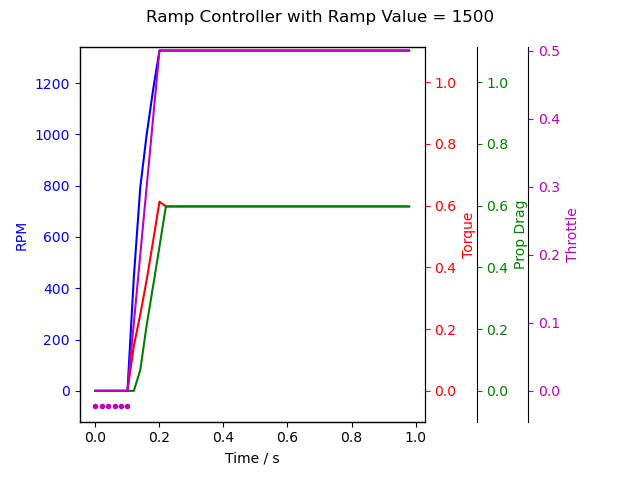

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


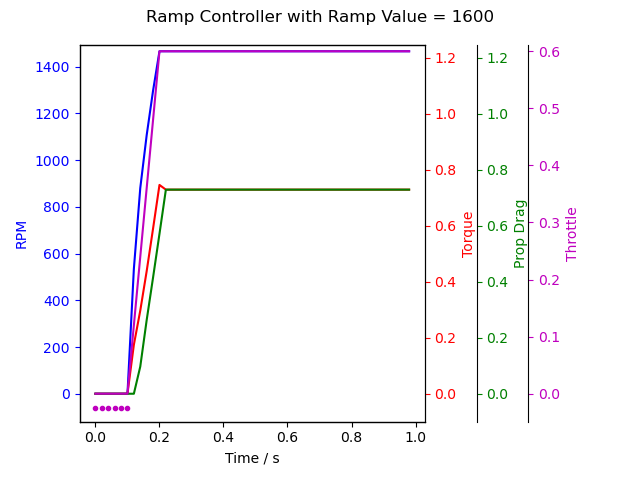

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


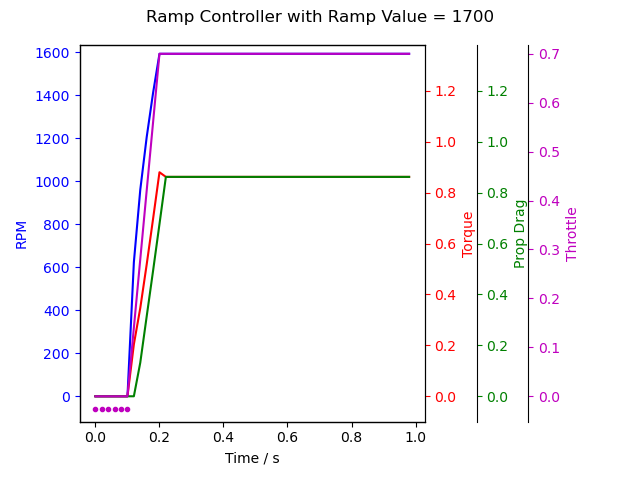

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


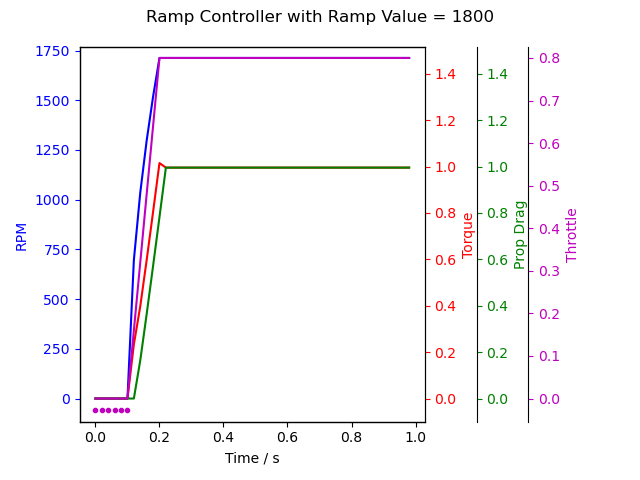

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


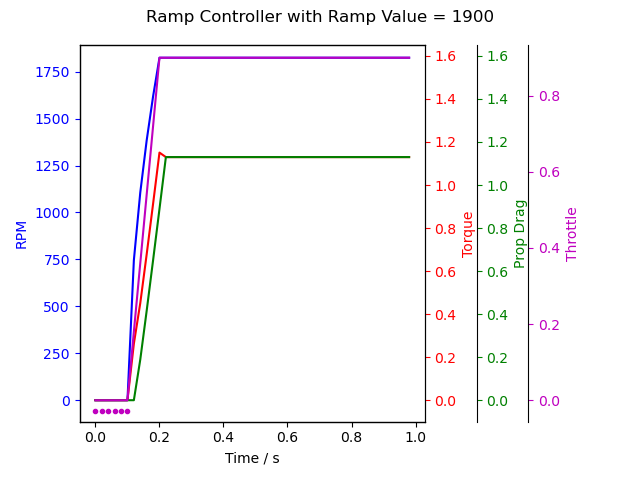

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


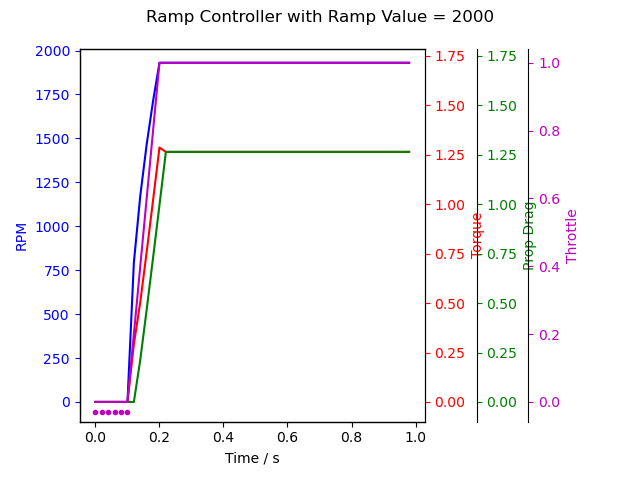

In [9]:
# Analyse the motor for ramp controllers with varying ramp values
# Plot the results
ramp_values = list(range(1100, 2001, 100))
for ramp_value in ramp_values:
	motor.reset()
	controller = RampController(final_value = ramp_value, dt = 0.02)
	df = simulate_motor(motor, controller, duration=1)
	plot_results(df, 'Ramp Controller with Ramp Value = ' + str(ramp_value))

### dt = 0.005

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


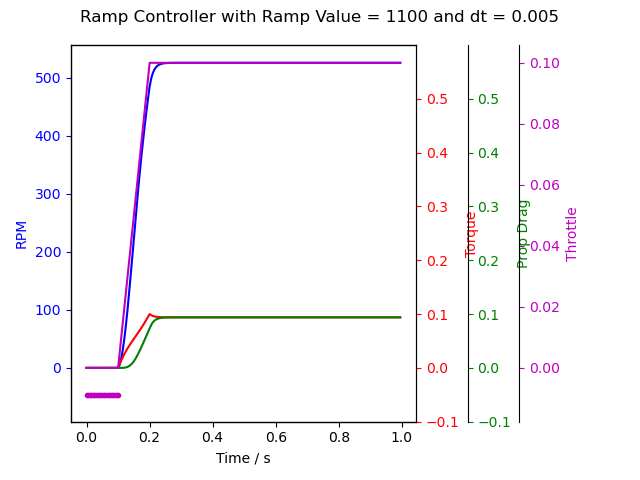

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


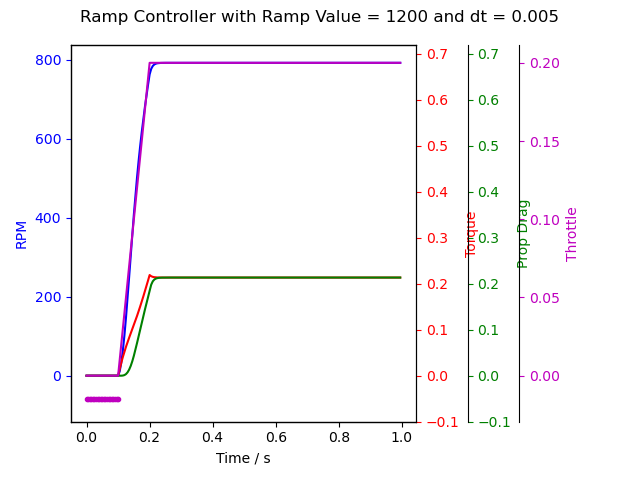

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


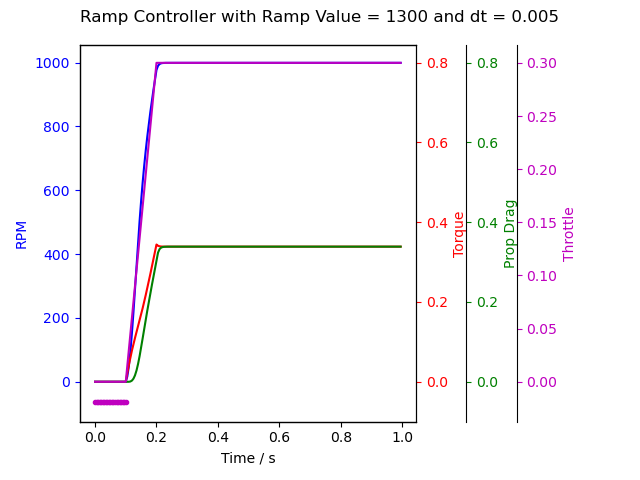

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


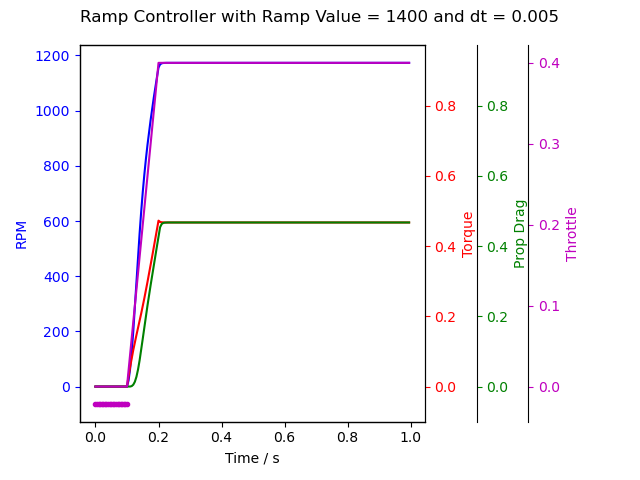

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


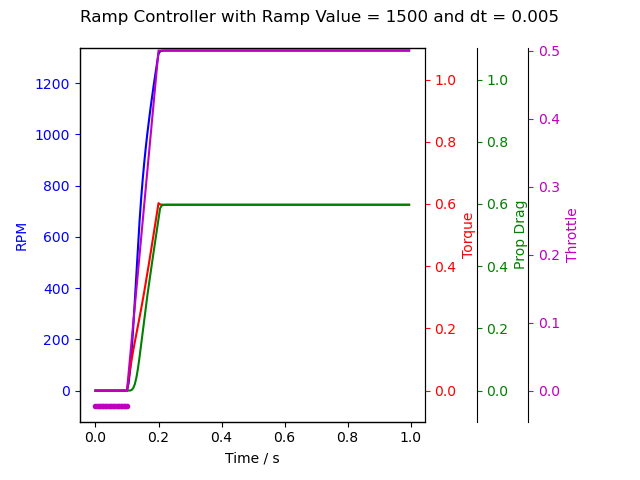

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


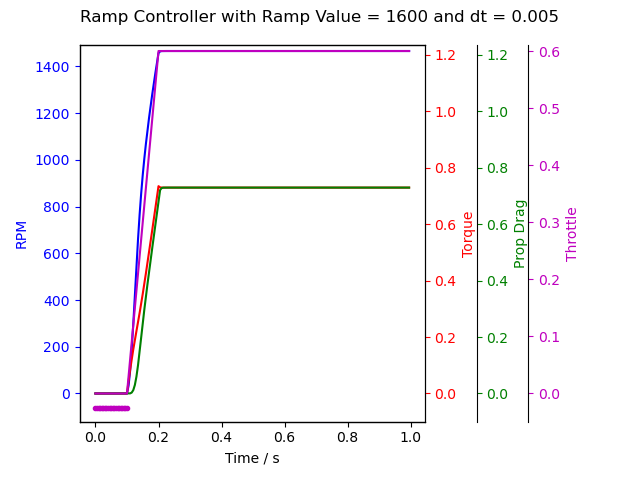

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


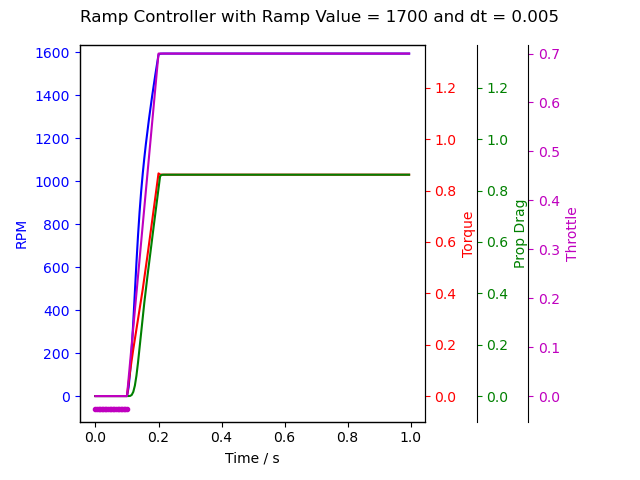

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


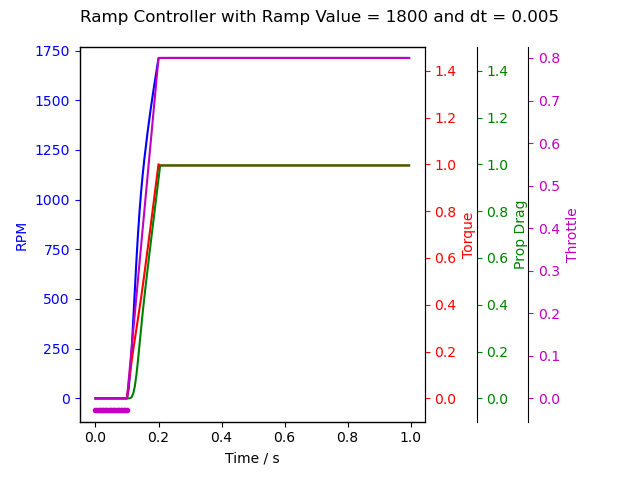

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


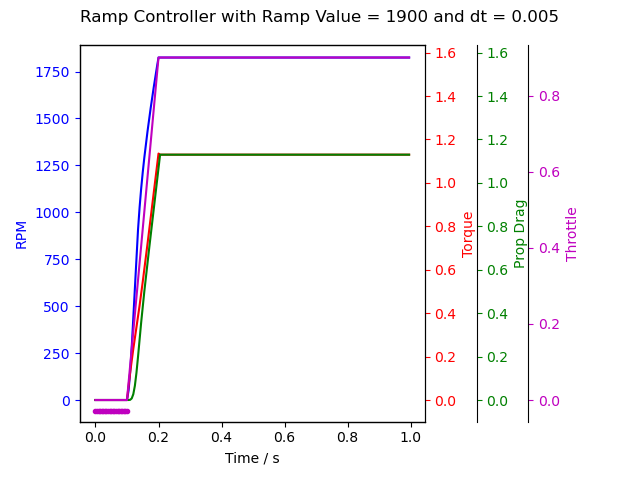

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


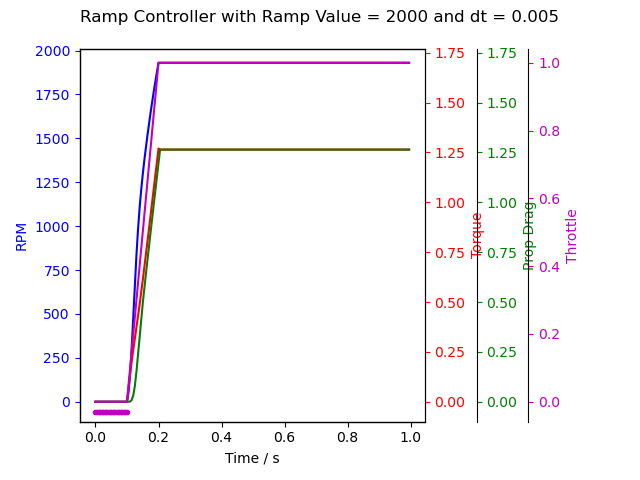

In [10]:
# Perform the same with dt = 0.005
for ramp_value in ramp_values:
	motor.reset()
	controller = RampController(final_value = ramp_value, dt = 0.005)
	df = simulate_motor(motor, controller, duration=1)
	plot_results(df, 'Ramp Controller with Ramp Value = ' + str(ramp_value) + ' and dt = 0.005')

## Pulse controller
### dt = 0.02

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


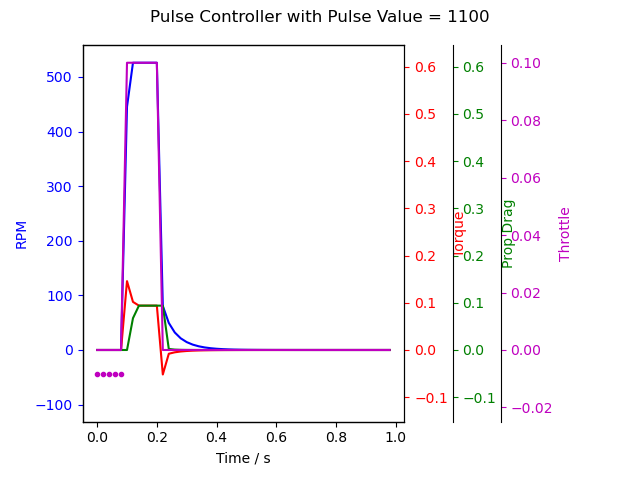

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


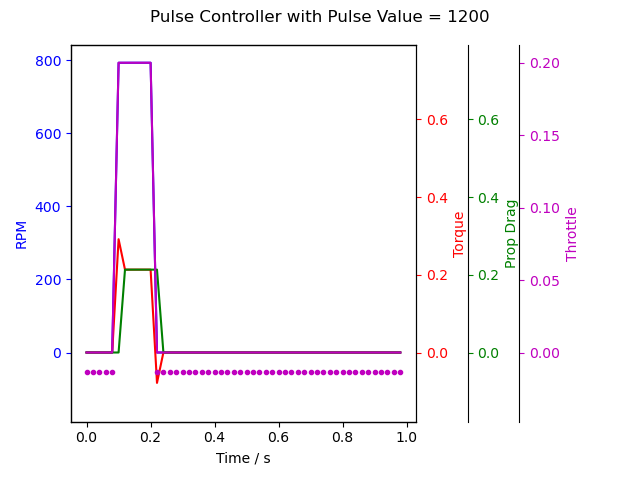

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


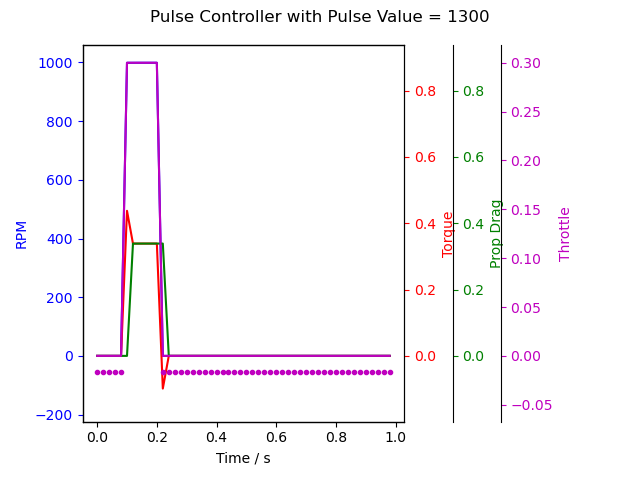

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


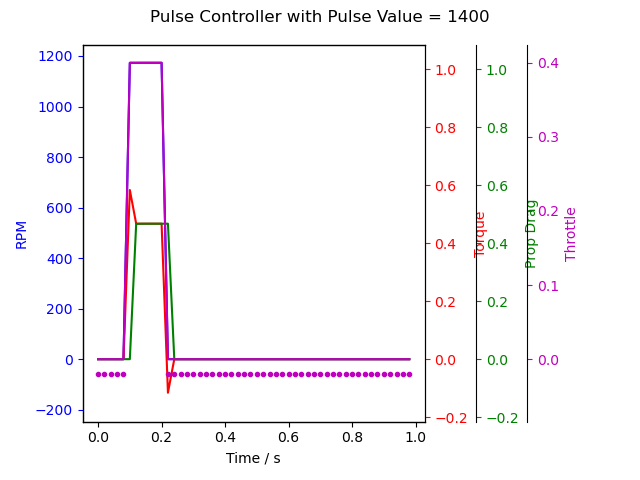

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


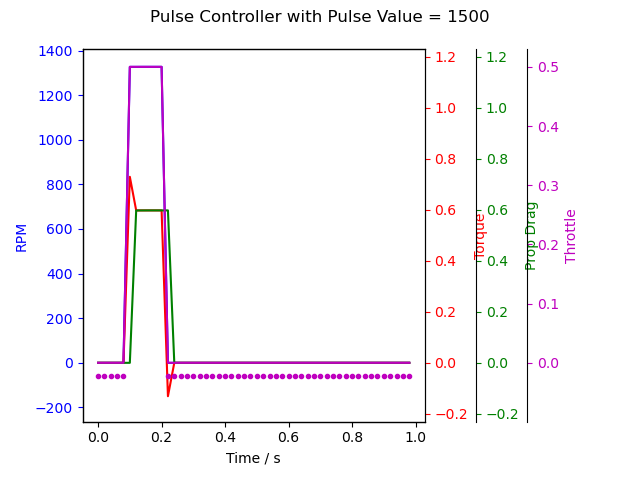

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


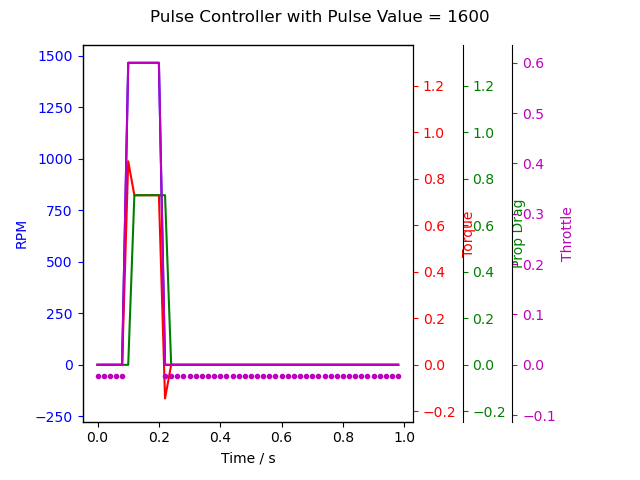

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


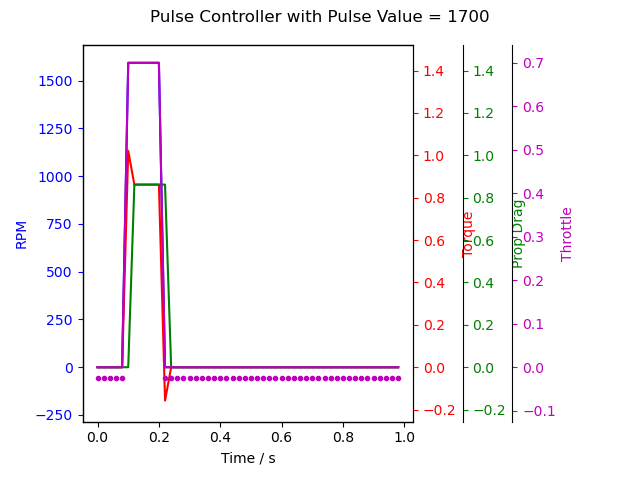

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


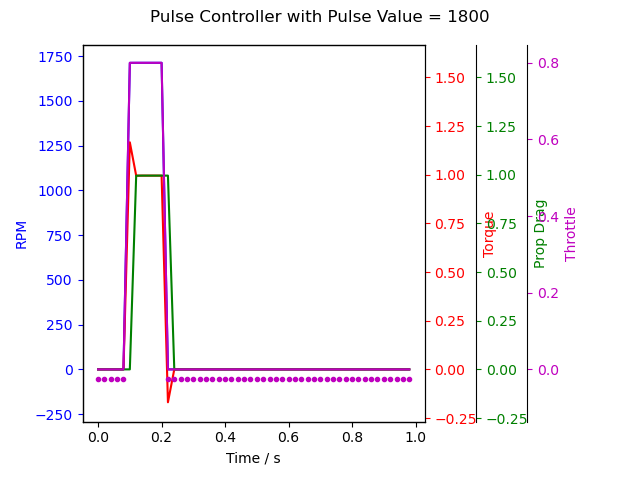

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


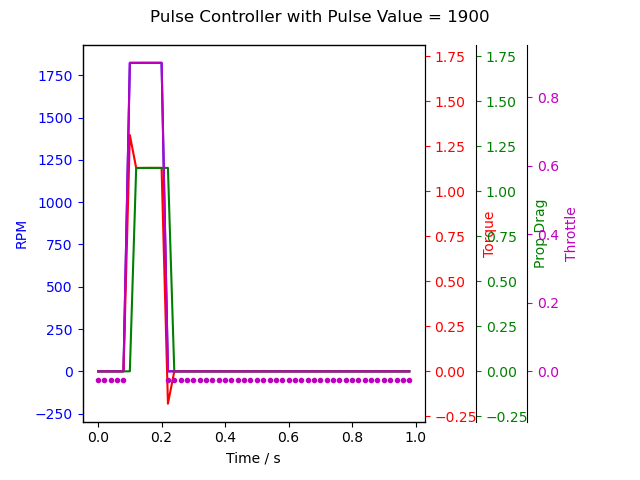

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


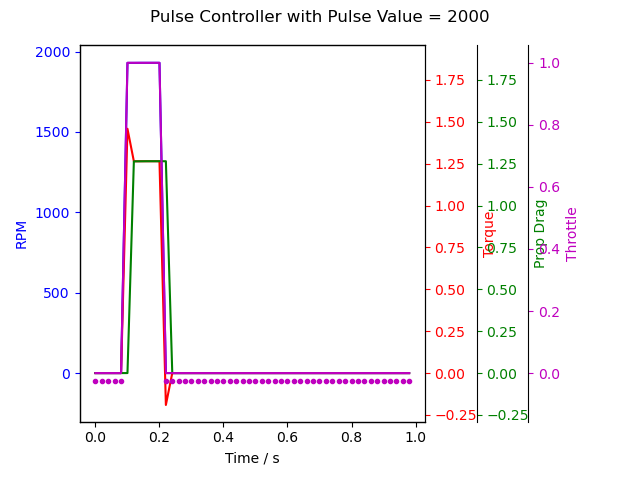

In [11]:
# Analyse the motor for pulse controllers with varying pulse values
# Plot the results
pulse_values = list(range(1100, 2001, 100))
for pulse_value in pulse_values:
	motor.reset()
	controller = PulseController(pulse_value = pulse_value, dt = 0.02)
	df = simulate_motor(motor, controller, duration=1)
	plot_results(df, 'Pulse Controller with Pulse Value = ' + str(pulse_value))

### dt = 0.005

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


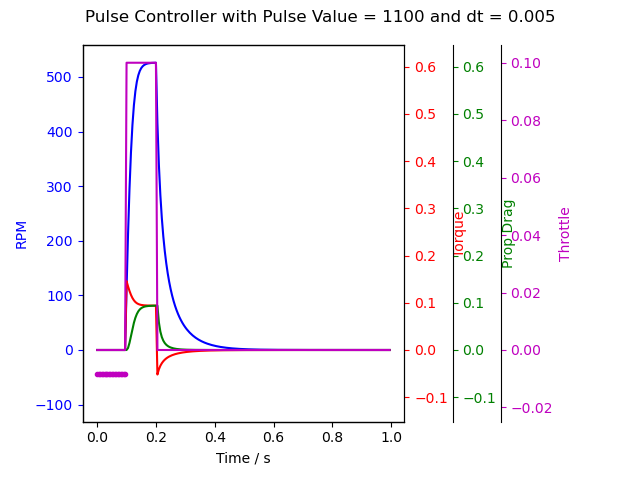

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


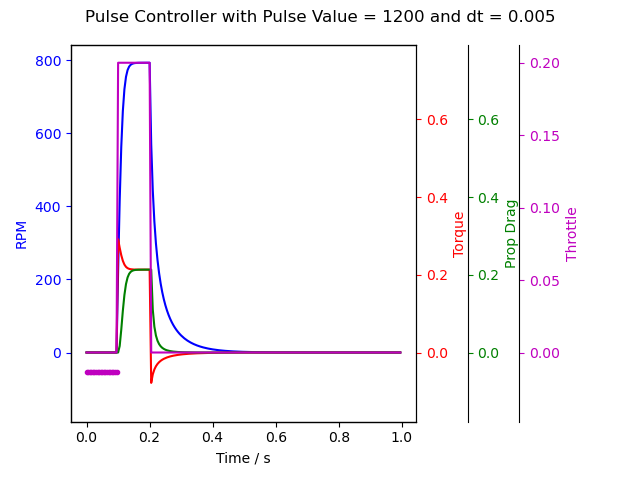

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


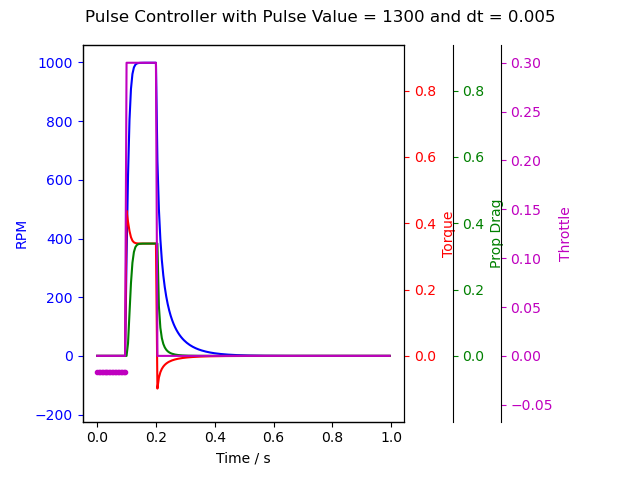

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


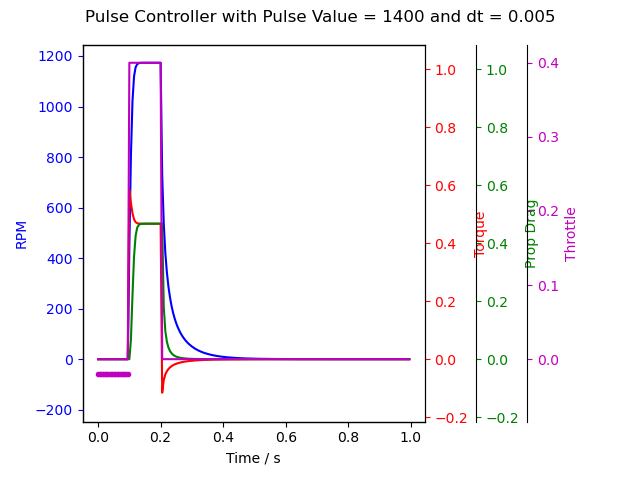

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


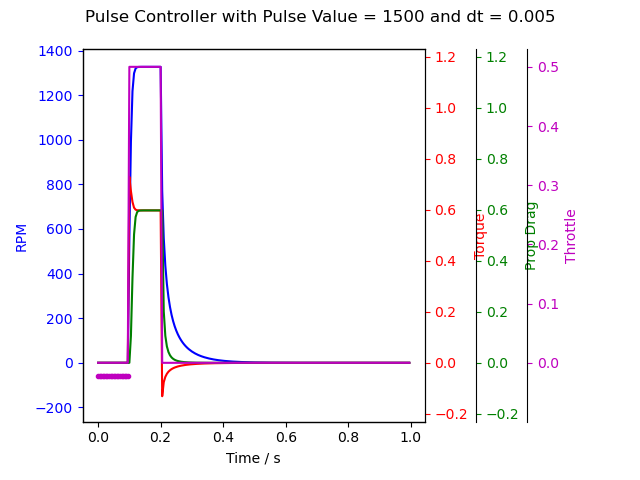

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


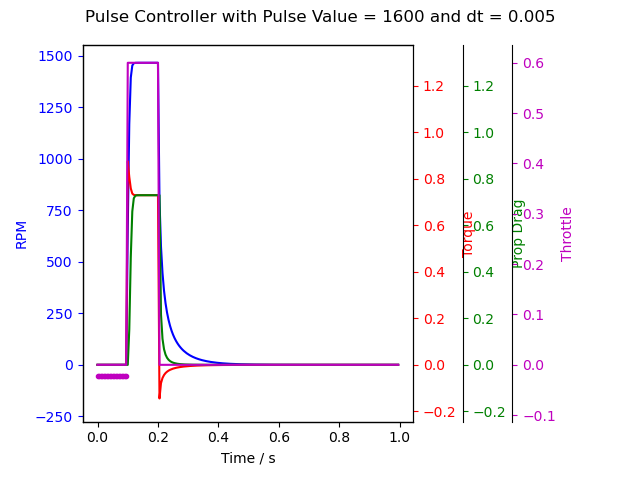

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


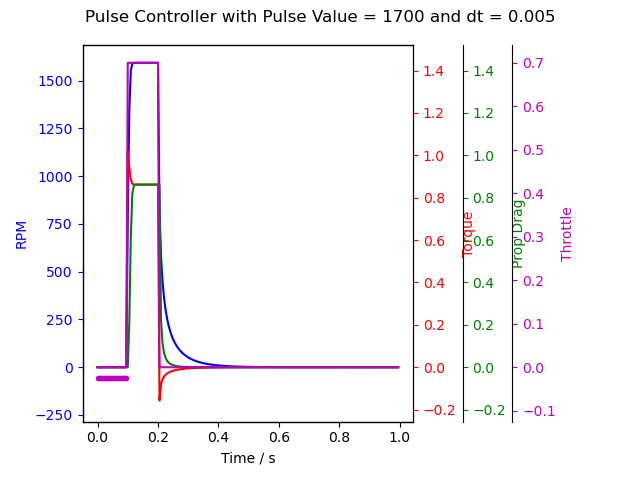

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


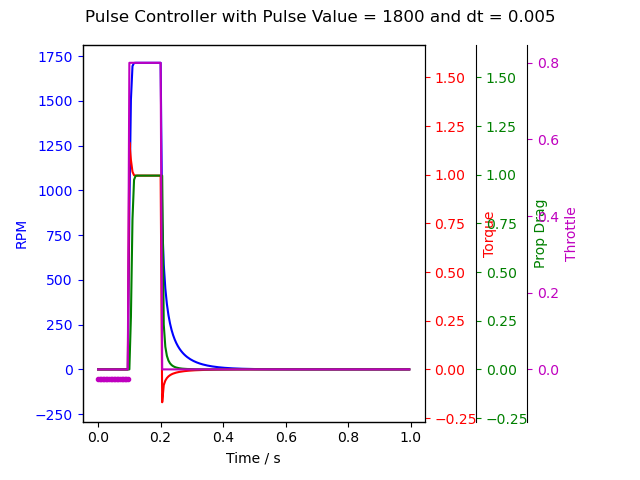

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


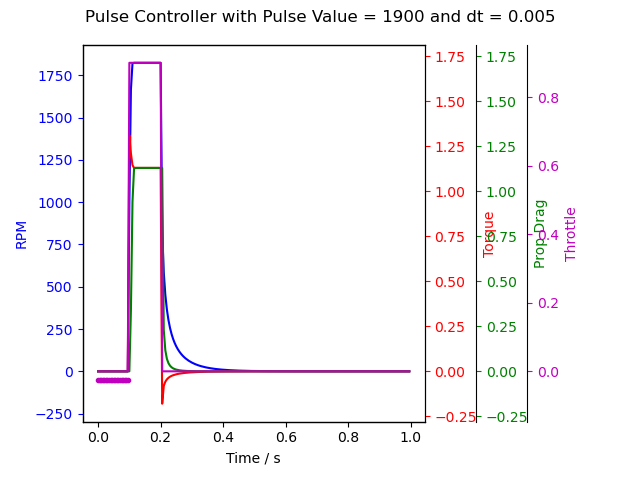

/tmp/ipykernel_15763/1896621683.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_row], axis = 0)


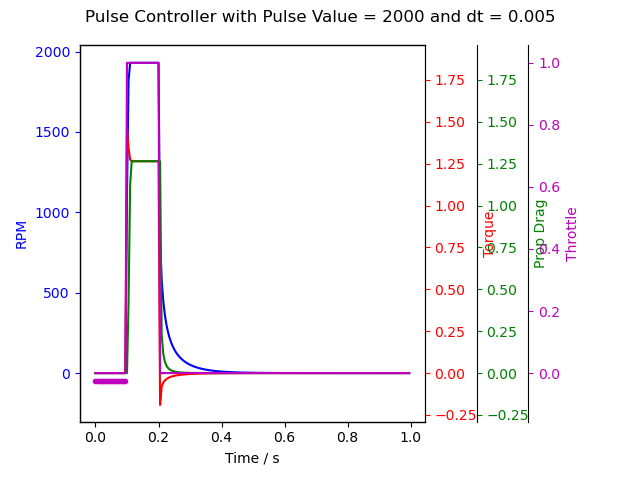

In [13]:
# Perform the same with dt = 0.005
for pulse_value in pulse_values:
	motor.reset()
	controller = PulseController(pulse_value = pulse_value, dt = 0.005)
	df = simulate_motor(motor, controller, duration=1)
	plot_results(df, 'Pulse Controller with Pulse Value = ' + str(pulse_value) + ' and dt = 0.005')